# Model and Dataset

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from skimage.color import gray2rgb, rgb2gray, label2rgb
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

import random
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
set_seed(100)

In [2]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5, padding = 1),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim = 1)
        )

    def forward(self, x): 
        x = self.conv_layers(x)
#         print (x.shape)
        x = x.view(-1, 500)
        x = self.fc_layers(x)
        return x



In [3]:
batch_size = 64
test_batch_size = 1000
epochs = 20
lr = .1
gamma = 0.7
use_cuda = torch.cuda.is_available()
seed = 10
log_interval = 10
save_model = True
Train_Flag = False

In [4]:
torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

transform=transforms.Compose([
    transforms.ToTensor(),
    lambda x: torch.cat ([x,x,x]) #Converting to 3 channels
#     transforms.Normalize((0.1307,), (0.3081,))
    ])


In [5]:

dataset_train = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset_test = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset_test, test_batch_size, shuffle = True)

In [6]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss()

In [7]:


def train(model, epoch, train_loader, optimizer, criterion, verbose = True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, epoch, test_loader, criterion, verbose = True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output.log(), target).item() * len (data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            acc))
    return acc
        

In [8]:

if Train_Flag:
    scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train(model, epoch, train_loader, optimizer, criterion)
        test(model, epoch, test_loader, criterion)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "ckpt.pth")
else:
    model.load_state_dict (torch.load("ckpt.pth"))
    epoch = 0
    acc = test (model, 0, test_loader, criterion, verbose = False)
    print ("loaded pretrained model with", acc, "% accuracy on test images")


loaded pretrained model with 98.71 % accuracy on test images


In [9]:
def filter_mask(mask, topp = 0.2):
    mask_torch = mask
    if isinstance (mask , np.ndarray):
        mask_torch = torch.tensor(mask)
    mask_linear = mask_torch.reshape(-1)
    _, mask_sortedargs = mask_linear.sort()
    mask_ones = torch.ones(len(mask_linear))
    mask_ones[:int(len(mask_linear) * (1-topp))] = 0.0
    mask_linear = mask_ones[mask_sortedargs.argsort()]
    
    return mask_linear.reshape(mask.shape)

class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, masks):
        self.data = data
        self.labels = labels
        self.masks = masks
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        filtered_mask = filter_mask (self.masks[idx])
        img = img * filtered_mask

        return img, label

def generate_masked_dataset(dataset, mask_generator, max_iters = 100):
    masks = []
    images = []
    labels = []
    
    if max_iters is not None:
        max_iters = min(max_iters, len(dataset))
    else:
        max_iters = len(dataset)
    
    dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle = True)
    set_seed(200)
    for i, (x,y) in tqdm (enumerate (dataloader), total = max_iters):
        x, y = deepcopy (x[0]), deepcopy (y[0])
        images.append(x)
        labels.append(y)    
        mask = mask_generator(x, y)
        masks.append(mask)
        if i > max_iters:
            break
    return MaskedDataset(images, labels, masks)

def normalize_and_permute(x):
    no = (x - x.min()) / (x.max() - x.min())
    if len(no.shape) == 3:
        no = no.permute([1,2,0])
    return no

def plot_in_row(dataset_test, idx):
    fig, ax = plt.subplots(1,2, figsize=(4, 2))
    ax[0].imshow (normalize_and_permute(dataset_test.data[idx]), cmap = "gray")
    ax[0].axis("off")
    ax[0].set_title("Image")
    ax[1].imshow (normalize_and_permute (dataset_test.__getitem__(idx)[0]), cmap = "gray")
    ax[1].axis("off")
    ax[1].set_title("Masked Image")
    plt.show()

# lime

In [10]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
model_lime = deepcopy (model)

In [11]:
def batch_predict(images):
    model_lime.eval()
    batch = torch.stack(tuple(torch.tensor (i).permute([2,0,1]) for i in images), dim=0)

    if (batch.dtype == torch.float64):
        batch = batch.to(torch.float32)  

    if (batch.dtype == torch.uint8):
        batch = batch.float()/255     

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_lime.to(device)
    batch = batch.to(device)
    
#     logits = model_lime(batch)
#     probs = F.softmax(logits, dim=1)
    probs = model_lime(batch)
    return probs.detach().cpu().numpy()

In [12]:
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                        max_dist=10, ratio=0.8,
                                        random_seed=100)

def limeExplanation(img, label):
    # img shape: [C, H, W]
    img = img.permute ([1,2,0]).to(torch.float64).numpy()
    explainer = lime_image.LimeImageExplainer(verbose = False)
    explanation = explainer.explain_instance(img, 
                                             batch_predict, # classification function
                                             top_labels=3, 
                                             hide_color=0, 
                                             num_samples=200, segmentation_fn=segmentation_fn) # number of images that will be sent to classification function
    
    mask_on_img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features = 2, hide_rest=False)
    img_boundry2 = mark_boundaries(mask_on_img, mask)
    return mask, img_boundry2, mask_on_img

def plotrow(ax, idx, img, mask, img_boundry2, mask_on_img):
    if isinstance(img, torch.Tensor):
        img = img.permute ([1,2,0]).numpy()

    ax[idx,0].imshow(img)
    ax[idx,0].set_title("Input")
    ax[idx,0].axis('off')

    ax[idx,1].imshow(mask)
    ax[idx,1].set_title("mask")
    ax[idx,1].axis('off')

    ax[idx,2].imshow(mask_on_img)
    ax[idx,2].set_title("mask on iamge")
    ax[idx,2].axis('off')

    ax[idx,3].imshow(img_boundry2)
    ax[idx,3].set_title("mask boundaries")
    ax[idx,3].axis('off')

In [13]:
imgs,labels = next (iter (test_loader))

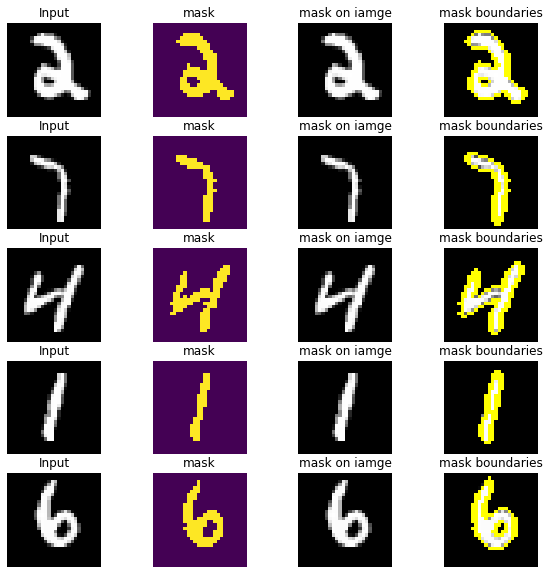

In [14]:

fig, ax = plt.subplots(5,4, figsize=(10, 10))
for i in range(5):
    img = imgs[i]
    label = labels[i].item()
    mask, img_boundry2, mask_on_img = limeExplanation(img, label)
    plotrow(ax, i, img, mask, img_boundry2, mask_on_img)

plt.show()

In [15]:
dataset_test_lime = generate_masked_dataset(dataset_test, mask_generator = lambda x, y : limeExplanation(x,y)[0], max_iters = 200)
test_loader_lime = torch.utils.data.DataLoader(dataset_test_lime, test_batch_size, shuffle = True)

In [16]:
acc_lime = test(model, epoch, test_loader_lime, criterion, verbose = False)
print (f"lime accuracy on mnist dataset is {acc_lime} ")

lime accuracy on mnist dataset is 94.55445544554455 


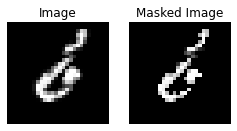

In [17]:
plot_in_row(dataset_test_lime, 10)

# Shapley (DeepExplainer)

In [18]:
model_shapley = deepcopy (model)

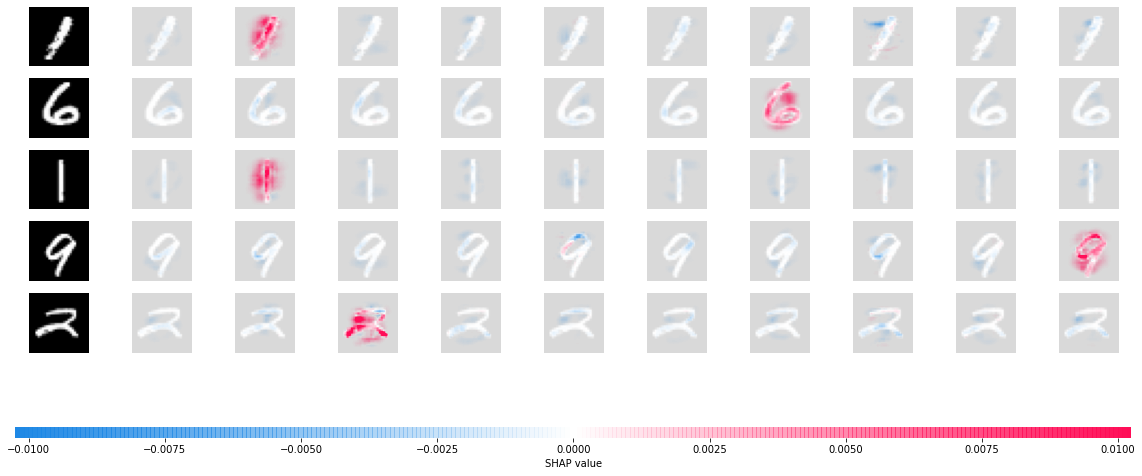

In [19]:
import shap
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)
model_shapley.eval()

test_batch_size = len(images)

background = images[:test_batch_size-5]
test_images = images[test_batch_size-5:]

e = shap.DeepExplainer(model_shapley, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

In [20]:
def shapExplanation(x,y):
    shap_values = e.shap_values(x[None].to(device))
    torch.cuda.empty_cache()
    return torch.tensor(shap_values[y][0]).sum(0)

In [21]:
dataset_test_shap = generate_masked_dataset(dataset_test, shapExplanation, max_iters = 200)
test_loader_shap = torch.utils.data.DataLoader(dataset_test_shap, test_batch_size, shuffle = True)

In [22]:
acc_shap = test(model, epoch, test_loader_shap, criterion, verbose = True)
print (f"shap accuracy on mnist dataset is {acc_shap} ")


Test set: Average loss: 0.0090, Accuracy: 202/202 (100%)

shap accuracy on mnist dataset is 100.0 


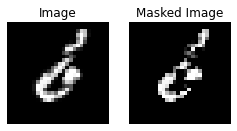

In [23]:
plot_in_row(dataset_test_shap, 10)

# LRP

In [24]:
import lrp
from visualization import project, clip_quantile, heatmap_grid, grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive # PatternNet patterns


In [25]:
def convert_to_lrp(model):
    new_model = torch.nn.ModuleList([])
    for l in model.conv_layers:
        if isinstance(l,torch.nn.Conv2d):
            new_model.append(lrp.Conv2d.from_torch(l))

        else:
            new_model.append(l)
    new_model.append(torch.nn.Flatten())
    for l in model.fc_layers:
        if isinstance(l,torch.nn.Linear):
            new_model.append(lrp.Linear.from_torch(l))
        elif isinstance(l,torch.nn.Softmax):
            continue
        else:
            new_model.append(l)
    new_model = lrp.Sequential(*new_model).to(device)
    return new_model

model_lrp = convert_to_lrp(deepcopy (model))

In [26]:
patterns = fit_patternnet_positive(model_lrp, train_loader, device=device)

100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 114.04it/s]


In [27]:

batch = next(iter(test_loader))
x, y = batch
x = x[:6]
y = y[:6]

x = x.to(device)
x = x.requires_grad_(True)

batch_to_append = batch[0][:31].clone()
batch_to_append = batch_to_append
batch_to_append = batch_to_append.requires_grad_(True)

In [28]:
def LRPMask(x, model_lrp, rule, patterns):
    x = x.to(device)
    x = x.detach()
    x.requires_grad_(True)
    
    # Forward pass
    y_hat_lrp = model_lrp.forward(x, explain=True, rule=rule, pattern=patterns)

    # Choose argmax
    y_hat_lrp = y_hat_lrp[torch.arange(x.shape[0]), y_hat_lrp.max(1)[1]]
    y_hat_lrp = y_hat_lrp.sum()

    # Backward pass (compute explanation)
    y_hat_lrp.backward()
    attr = x.grad    
    return attr

def compute_and_plot_explanation(x, model_lrp, rule, ax_, patterns=None, plt_fn=heatmap_grid): 
    
    attr = LRPMask(x, model_lrp, rule, patterns)

    # Plot
    attr = plt_fn(attr)

    ax_.imshow(attr)
    ax_.set_title(rule)
    ax_.axis('off')
# PatternNet is typically handled a bit different, when visualized.
def signal_fn(X):
    if X.shape[1] in [1, 3]: X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    X = clip_quantile(X)
    X = project(X)
    X = grid(X)
    return X

def lrpExplanation(x, y):
    return LRPMask(torch.cat ([x[None],batch_to_append]), model_lrp, rule = 'alpha1beta0', patterns = None)[0].cpu().sum(0)

Plotting


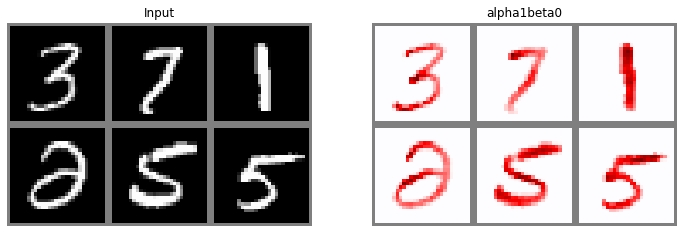

In [29]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   1), 
    ]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0].imshow(input_to_plot)
ax[0].set_title("Input")
ax[0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, p ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p], patterns=pattern, plt_fn=fn)



In [30]:
dataset_test_lrp = generate_masked_dataset(dataset_test, lrpExplanation, max_iters = 200)

In [31]:
test_loader_lrp = torch.utils.data.DataLoader(dataset_test_lrp, test_batch_size, shuffle = True)
acc_lrp = test(model, epoch, test_loader_lrp, criterion, verbose = True)
print (f"lrp accuracy on mnist dataset is {acc_lrp} ")


Test set: Average loss: 0.0201, Accuracy: 202/202 (100%)

lrp accuracy on mnist dataset is 100.0 


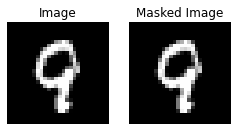

In [32]:
plot_in_row(dataset_test_lrp, 21)

# Comparing Methods

In [33]:
import seaborn as sns
sns.set_style('dark')
# sns.set_style('white')
sns.set_context('notebook', font_scale=1.4, rc={'lines.linewidth': 1.2})
# sns.set(rc={'figure.facecolor':'cornflowerblue'})
# sns.set(rc={'figure.facecolor':'cornflowerblue'})
sns.set_palette('bright')

sns.despine()

<Figure size 432x288 with 0 Axes>

In [34]:
names = ['lime', 'shapley', 'lrp']
accs = [acc_lime, acc_shap, acc_lrp]

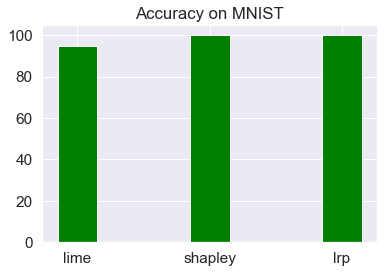

In [35]:

# Horizontal Bar Plot
plt.figure(figsize = (6,4))
plt.bar(names, accs, width = 0.3, color = 'green')
plt.title('Accuracy on MNIST')
plt.grid()
# Show Plot
plt.show()
